# Gradient-Boosting Machine (XGBoost) - With Tuned Hyperparameters
### *Exploring the association between neoantigen-related variables and immune scores*
This notebook is the continuation of the `xgboost.ipynb` notebook, which details hyperparameter tuning grid search with cross-validation to model interactions of select X features on a subset of Y labels (based on the PCA work done by Caitlin from GB team). 

#### **Package and Raw Data Loading**
First, import necessary packages and load in the raw data table into `pandas` dataFrame. 



In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import YeoJohnsonTransformer

from warnings import simplefilter, filterwarnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

Load up the cleaned-up dataset wrangled from MH's latest work.

In [43]:
# read in latest data
# use the 202409_new_excludedIHC_batch-duplicate-removed.tsv
df = pd.read_csv("../input-data/SA/202409_new_excludedIHC_batch-duplicate-removed.tsv",sep="\t")
print(df.shape)

#print row 107 and 226
df.iloc[[107,226,555,872], :25]

(953, 156)


,ID,Batch,PAM50,Subtype,HR_status,HER_status,Age,AgeGroup,Stage,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestScore,FusionTransscript_Count,Fusion_T2NeoRate,SNVindelNeo_Count,SNVindelNeo_IC50,SNVindelNeo_IC50Percentile,TotalNeo_Count,ESTIMATE,IMPRES,Bindea_full,Expanded_IFNg,C_Bcellsnaive,C_Bcellsmemory
107,SD0299,Batch_1,LumA,HR+/HER2-,HR+,HER2-,60.0,51-60,2.0,2.0,3.0,NaN,NaN,10.0,NaN,153.0,3.9,0.0038,NaN,2706.111665,9.0,-0.2558,-0.7362,0.078713,0.0
226,SD0787,Batch_1,LumA,HR+/HER2-,HR+,HER2-,66.0,61-70,3.0,2.0,2.5,NaN,NaN,12.0,NaN,141.0,3.8,0.0040,NaN,2809.623846,9.0,-0.2755,-0.8429,0.164741,0.0
555,B13822,Batch_2,Her2,TNBC,HR-,HER2-,67.0,61-70,1.0,NaN,1.6,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,5273.837913,10.0,0.0110,0.6930,0.118868,0.0
872,SD2132,Batch_2,Basal,TNBC,HR-,HER2-,56.0,51-60,2.0,2.0,2.6,48.0,10.86,85.0,0.564705882,2179.0,1.8,0.0010,2227.0,3518.159157,10.0,-0.3685,0.1545,0.106324,0.0


In [44]:
# exclude the 29 Cibersort scores, leaving only 3
df = df.drop(columns=['Bindea_full', 'Expanded_IFNg', 
        'C_Bcellsmemory','C_Plasmacells','C_TcellsCD8','C_TcellsCD4naive',
         'C_TcellsCD4memoryactivated','C_Tcellsfollicularhelper',
         'C_Tcellsregulatory(Tregs)','C_Tcellsgammadelta','C_NKcellsresting',
         'C_NKcellsactivated', 'C_Monocytes', 'C_MacrophagesM0',
         'C_MacrophagesM1','C_Dendriticcellsresting',
         'C_Dendriticcellsactivated', 'C_Mastcellsresting',
         'C_Mastcellsactivated','C_Eosinophils', 'C_Neutrophils', 'S_PAM100HRD'])

print(df.shape)
df.head()

(953, 134)


,ID,Batch,PAM50,Subtype,HR_status,HER_status,Age,AgeGroup,Stage,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestScore,FusionTransscript_Count,Fusion_T2NeoRate,SNVindelNeo_Count,SNVindelNeo_IC50,SNVindelNeo_IC50Percentile,TotalNeo_Count,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
0,SD0012,Batch_1,LumB,HR+/HER2-,HR+,HER2-,50.0,41-50,2.0,2.0,2.3,20.0,5.79,42.0,0.476190476,357.0,1.7,0.0025,377.0,2895.605487,9.0,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
1,SD0014,Batch_1,LumA,HR+/HER2-,HR+,HER2-,58.0,51-60,2.0,2.0,2.5,10.0,5.28,17.0,0.588235294,85.0,4.1,0.0039,95.0,4257.831526,11.0,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.27

#### **Data Preprocessing**

Decide all the clinical variables and neoantigen-related variables to keep in the X matrix (features).

1. `Subtype` column has already been encoded categorically by `HR_status` and `HER_status` columns so these two columns can be dropped. ***UPDATE: due to their lesser importance during the default XGBoost modeling, `PAM50` column was dropped as well.***

2.  `AgeGroup` is just a binned information of `Age` column so it is dropped as it is redundant.

3. Drop `FusionNeo_bestScore`, `FusionTransscript_Count`, `Fusion_T2NeoRate` columns as well as the `SNVindelNeo_IC50` and `SNVindelNeo_IC50Percentile` columns for now to reduce complexity.

4. Drop `Batch` column.

> **UPDATE 1: Exclude `TotalNeo_Count`, and include `Fusion_T2NeoRate` and `SNVindelNeo_IC50` columns. Also, rename `Fusion_T2NeoRate` to `FN/FT_Ratio`.**

> **UPDATE 2: put back `FusionNeo_bestScore` into the X variable set and rename it into `FusionNeo_bestIC50`**

In [45]:
# let's drop all NaN for now and set col 'ID' as index
dfd = df.drop(columns = ['Batch', 'Stage', 'PAM50', 'HR_status', 'HER_status', 'AgeGroup', 'TotalNeo_Count', 'FusionTransscript_Count', 'SNVindelNeo_IC50Percentile']).dropna().set_index('ID')
print(dfd.shape)
dfd.head()

(674, 124)


,Subtype,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestScore,Fusion_T2NeoRate,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,HR+/HER2-,50.0,2.0,2.3,20.0,5.79,0.476190476,357.0,1.7,2895.605487,9.0,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,HR+/HER2-,58.0,2.0,2.5,10.0,5.28,0.588235294,85.0,4.1,4257.831526,11.0,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,HR+/HER2-,46.0,2.0,1.8,4.0,11.48,0.25,150.0

In [46]:
# rename the column `Fusion_T2NeoRate` to `FN/FT_Ratio` and `FusionNeo_bestScore` to `FusionNeo_bestIC50`
dfd.rename(columns={'Fusion_T2NeoRate': 'FN/FT_Ratio'}, inplace=True)
dfd.rename(columns={'FusionNeo_bestScore': 'FusionNeo_bestIC50'}, inplace=True)

In [47]:
dfd.head()

,Subtype,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,HR+/HER2-,50.0,2.0,2.3,20.0,5.79,0.476190476,357.0,1.7,2895.605487,9.0,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,HR+/HER2-,58.0,2.0,2.5,10.0,5.28,0.588235294,85.0,4.1,4257.831526,11.0,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,HR+/HER2-,46.0,2.0,1.8,4.0,11.48,0.25,150.0,2.4,3

**Sanity Check:** Check to make sure there is no duplicated index rows in the dataset.

In [48]:
print(dfd.index[dfd.index.duplicated()].unique())
rows_dupe = list(dfd.index[dfd.index.duplicated()].unique())
rows_dupe

Index([], dtype='object', name='ID')


[]

Now we can encode categorical variables and integer variables accordingly so they are more amenable to machine learning algorithms. 

Check data types of the resulting cleaned up dataFrame.

In [49]:
# check original df's dtypes
pd.set_option('display.max_rows', None)
dfd.dtypes

Subtype                            object
Age                               float64
TumorGrade                        float64
TumourSize                        float64
FusionNeo_Count                   float64
FusionNeo_bestIC50                float64
FN/FT_Ratio                        object
SNVindelNeo_Count                 float64
SNVindelNeo_IC50                  float64
ESTIMATE                          float64
IMPRES                            float64
C_Bcellsnaive                     float64
C_TcellsCD4memoryresting          float64
C_MacrophagesM2                   float64
S_Attractors_LYM                  float64
S_Attractors_IFIT3                float64
S_Attractors_G_GIMAP4             float64
S_Attractors_G_HLA.DPA1           float64
S_Attractors_G_SLAMF6             float64
S_Attractors_G_LILRB4             float64
S_Attractors_G_SIGLEC9            float64
S_Attractors_G_CYTH4              float64
S_Attractors_G_CD3E               float64
S_Lymph_Vessels                   

We need to encode the `object` columns of `Subtype` and `FN/FT_Ratio` into appropriate types. Change `Age`, `TumorGrade`, and `IMPRES` into `int64` as well as all `*_Count` columns because they are discrete variables. Change the `FN/FT_Ratio` into `float64`.

In [50]:
dfd['Subtype'] = dfd['Subtype'].astype('category')
dfd['Age'] = dfd['Age'].astype('int64')
dfd['TumorGrade'] = dfd['TumorGrade'].astype('int64')
dfd['IMPRES'] = dfd['IMPRES'].astype('int64')
dfd['FusionNeo_Count'] = dfd['FusionNeo_Count'].astype('int64')
dfd['SNVindelNeo_Count'] = dfd['SNVindelNeo_Count'].astype('int64')
dfd['FN/FT_Ratio'] = dfd['FN/FT_Ratio'].astype('float64')

print(dfd.dtypes)

Subtype                           category
Age                                  int64
TumorGrade                           int64
TumourSize                         float64
FusionNeo_Count                      int64
FusionNeo_bestIC50                 float64
FN/FT_Ratio                        float64
SNVindelNeo_Count                    int64
SNVindelNeo_IC50                   float64
ESTIMATE                           float64
IMPRES                               int64
C_Bcellsnaive                      float64
C_TcellsCD4memoryresting           float64
C_MacrophagesM2                    float64
S_Attractors_LYM                   float64
S_Attractors_IFIT3                 float64
S_Attractors_G_GIMAP4              float64
S_Attractors_G_HLA.DPA1            float64
S_Attractors_G_SLAMF6              float64
S_Attractors_G_LILRB4              float64
S_Attractors_G_SIGLEC9             float64
S_Attractors_G_CYTH4               float64
S_Attractors_G_CD3E                float64
S_Lymph_Ves

Now we can use Feature_Engine's `OneHotEncoder()` to create a `k` dummy variable set for `Subtype`.

**NOTE**: The encoded columns will be appended at the end of the dataFrame. 


In [51]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(
    variables=['Subtype'],
    drop_last=False)

encoder.fit(dfd)
dfd_ = encoder.transform(dfd)
dfd_.head()

,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530,1,0,0,0
SD0014,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606,1,0,0,0
SD0015,46,2,1.8,4,11.48,

In [52]:
# Specify the encoded columns to shift
enc_cols = ['Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']

# Drop the specified columns and store them
encoded_df = dfd_[enc_cols]
dfenc = dfd.drop(columns=['Subtype'])

# Specify the index where you want to reinsert the columns
insert_index = 0  # This will insert at the first column

# Reinsert the columns
for i, col in enumerate(encoded_df.columns):
    dfenc.insert(insert_index + i, col, encoded_df[col])

Below is the categorically-encoded dataframe.

In [53]:
print(dfenc.shape)
dfenc.head()

(674, 127)


,Subtype_HR+/HER2-,Subtype_HR+/HER2+,Subtype_TNBC,Subtype_HR-/HER2+,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,1,0,0,0,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,1,0,0,0,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,1,0,0,0,46,2,1.8,

And below is the original, unencoded dataframe.

In [54]:
print(dfd.shape)
dfd.head()

(674, 124)


,Subtype,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,HR+/HER2-,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,HR+/HER2-,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,HR+/HER2-,46,2,1.8,4,11.48,0.250000,150,2.4,3123.055856,8,0.162653,0.235337

#### **Subsetting Y Labels for XGBoost**

In the previous exploration, many of the immune scores (Y targets/labels) might not really show much relationship with fusion neoantigen variables so they may not be as informative. We decided to use Caitlin's finding and subset the Y labels into several clinically meaningful groups.

In [55]:
# use the unencoded categorical dataframe (dfd) and drop the Subtype categorical column
df_dcat = dfd.drop(columns=['Subtype'])
print(df_dcat.shape)
df_dcat.head()

(674, 123)


,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,ESTIMATE,IMPRES,C_Bcellsnaive,C_TcellsCD4memoryresting,C_MacrophagesM2,S_Attractors_LYM,S_Attractors_IFIT3,S_Attractors_G_GIMAP4,S_Attractors_G_HLA.DPA1,S_Attractors_G_SLAMF6,S_Attractors_G_LILRB4,S_Attractors_G_SIGLEC9,S_Attractors_G_CYTH4,S_Attractors_G_CD3E,S_Lymph_Vessels,S_ICR_SCORE,S_ICR_INHIB_SCORE,S_ICR_ACT_SCORE,S_Angiogenesis,S_APM1,S_APM2,S_ICS5_score,S_LIexpression_score,S_Chemokine12_score,S_NHI_5gene_score,S_CD68,S_CD8A,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_CTLA4_data,S_Bcell_mg_IGJ,S_Bcell_receptors_score,S_STAT1_score,S_CSF1_response,S_TcClassII_score,S_IL12_score_21050467,S_IL4_score_21050467,S_IL2_score_21050467,S_IL13_score_21050467,S_IFNG_score_21050467,S_TGFB_score_21050467,S_TREM1_data,S_DAP12_data,S_Tcell_receptors_score,S_IL8_21978456,S_IFN_21978456,S_MHC1_21978456,S_MHC2_21978456,S_Bcell_21978456,S_Tcell_21978456,S_CD103pos_mean_25446897,S_CD103neg_mean_25446897,S_IgG_19272155,S_Interferon_19272155,S_LCK_19272155,S_MHC.I_19272155,S_MHC.II_19272155,S_STAT1_19272155,S_Troester_WoundSig_19887484,S_MDACC.FNA.1_20805453,S_IGG_Cluster_21214954,S_Minterferon_Cluster_21214954,S_Immune_cell_Cluster_21214954,S_MCD3_CD8_21214954,S_Interferon_Cluster_21214954,S_B_cell_PCA_16704732,S_CD8_PCA_16704732,S_GRANS_PCA_16704732,S_LYMPHS_PCA_16704732,S_T_cell_PCA_16704732,S_TGFB_PCA_17349583,S_Rotterdam_ERneg_PCA_15721472,S_HER2_Immune_PCA_18006808,S_IR7_score,S_Buck14_score,S_TAMsurr_score,S_Immune_NSCLC_score,S_Module3_IFN_score,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_Module11_Prolif_score,S_CD8_CD68_ratio,S_TAMsurr_TcClassII_ratio,S_CHANG_CORE_SERUM_RESPONSE_UP,S_CSR_Activated_15701700,S_B_cells,S_T_cells,S_T_helper,S_Tcm,S_Tem,S_Th1,S_Th2,S_TFH,S_CD8_Tcells,S_Th17,S_Treg,S_Tgd,S_Cytotoxic_cells,S_NK_cells,S_NK_cd56dim,S_NK_cd56bright,S_DC,S_iDC,S_aDC,S_pDC,S_Eosinophils,S_Macrophages,S_Mast,S_Neutrophils,S_Bindea_full,S_Expanded_IFNg,S_KEGG_MMR,S_KEGG_TGF_Beta,S_KEGG_Cytosolic_DNA_Sensing
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,50,2,2.3,20,5.79,0.476190,357,1.7,2895.605487,9,0.120394,0.117468,0.448450,0.3620,0.4216,0.3034,0.4425,0.2749,0.2983,0.2756,0.3121,0.2765,0.3203,0.2463,0.2341,0.2495,0.3571,0.4591,0.3985,0.2130,0.2223,0.2766,0.3573,0.1561,0.2942,0.1536,0.2530,0.2042,0.2061,0.1942,0.2764,0.3327,0.3795,0.3435,0.2846,0.3797,0.3761,0.3197,0.4008,0.4403,0.2907,0.4011,0.2526,0.2237,0.4256,0.3971,0.4477,0.1852,0.2516,0.2262,0.3854,0.1591,0.4462,0.2912,0.4211,0.4502,0.3610,0.2711,0.3414,0.2183,0.3728,0.3512,0.3529,0.4162,0.3612,0.2215,0.3614,0.4294,0.3451,0.4648,0.2937,0.3338,0.2999,0.2094,0.2743,0.3203,0.4136,0.2546,0.2730,0.3697,0.2268,0.3335,0.3959,0.4066,0.2199,0.2395,0.4132,0.3633,0.3210,0.2599,0.3561,0.3112,0.3645,0.2810,0.2348,0.1945,0.2188,0.3281,0.0602,0.2038,0.2445,0.3220,0.2212,0.2866,0.3030,0.3657,0.2499,0.2531,0.3031,0.3097,0.4053,0.3537,0.2530
SD0014,58,2,2.5,10,5.28,0.588235,85,4.1,4257.831526,11,0.165023,0.207531,0.124223,0.4126,0.3815,0.3619,0.4760,0.3343,0.3001,0.2769,0.3761,0.3525,0.3452,0.3051,0.2701,0.3143,0.3803,0.4819,0.4125,0.3002,0.3106,0.3646,0.3753,0.1030,0.3644,0.2726,0.2377,0.2553,0.2513,0.2820,0.3079,0.3515,0.3869,0.3868,0.3133,0.4051,0.4031,0.3308,0.4120,0.4496,0.2012,0.4360,0.3290,0.2562,0.3882,0.4310,0.4682,0.2990,0.3007,0.2859,0.3998,0.2225,0.4068,0.3481,0.4494,0.4710,0.4011,0.2840,0.3779,0.2727,0.3831,0.3864,0.3511,0.3983,0.3676,0.2761,0.3637,0.4268,0.3555,0.4580,0.3266,0.3549,0.3763,0.2157,0.3028,0.3278,0.3896,0.3111,0.3159,0.3126,0.2395,0.3747,0.3838,0.4030,0.2731,0.2909,0.4092,0.3404,0.3530,0.2808,0.3102,0.3229,0.3713,0.2645,0.3182,0.1977,0.2985,0.3502,0.1191,0.3316,0.2976,0.3445,0.2403,0.3450,0.3203,0.3484,0.2768,0.2783,0.3200,0.3668,0.3803,0.3470,0.2606
SD0015,46,2,1.8,4,11.48,0.250000,150,2.4,3123.055856,8,0.162653,0.235337,0.279972,0.3556,0.3782,0.3363,0.4718,0

First list all the clinical variables that would be the X feature set.

In [56]:
X_features = ['Age', 'TumorGrade', 'TumourSize', 'Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

In [96]:
X_features_nocat = ['Age', 'TumorGrade', 'TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

In [60]:
# Now get the Y variable set
Y_labels_all = [col for col in df_dcat.columns if col not in X_features]
print(Y_labels_all[:5])
len(Y_labels_all)

['ESTIMATE', 'IMPRES', 'C_Bcellsnaive', 'C_TcellsCD4memoryresting', 'C_MacrophagesM2']


115

In [70]:
# load up the tsv containing the groupings of the different immune scores
df_imscores = pd.read_csv('../input-data/SA/immune_score_groupings.tsv', sep='\t')
df_imscores.head()

,HR>1,HR>1_worst_10_prog,HR<1,HR<1_best_10_prog,cytokine_chemokine_activator,activator_T,suppressor_T,B_cell_all,innate_cell_all,general
0,S_TREM1_data,S_TGFB_score_21050467,S_Buck14_score,S_Buck14_score,S_Expanded_IFNg,S_T_cells,S_Treg,S_CSR_Activated_15701700,S_pDC,S_Buck14_score
1,S_CHANG_CORE_SERUM_RESPONSE_UP,S_TGFB_PCA_17349583,S_Bcell_receptors_score,S_Bcell_receptors_score,S_IL2_score_21050467,S_Tcell_receptors_score,S_TGFB_score_21050467,S_Bcell_receptors_score,NaN,S_Rotterdam_ERneg_PCA_15721472
2,S_IL8_21978456,S_Lymph_Vessels,S_TFH,S_TFH,S_IL12_score_21050467,S_Tcell_21978456,S_CTLA4_data,S_B_cell_PCA_16704732,NaN,S_KEGG_Cytosolic_DNA_Sensing
3,NaN,S_Rotterdam_ERneg_PCA_15721472,S_CD103pos_mean_25446897,S_CD103pos_mean_25446897,S_IFNG_score_21050467,S_CD8_Tcells,S_PD1_data,NaN,NaN,NaN
4,NaN,S_IFNG_score_21050467,S_T_helper,S_T_helper,S_IR7_score,S_CD8A,S_PDL1_data,NaN,NaN,NaN


In [71]:
df_imscores.columns

Index(['HR>1', 'HR>1_worst_10_prog', 'HR<1', 'HR<1_best_10_prog',
       'cytokine_chemokine_activator', 'activator_T', 'suppressor_T',
       'B_cell_all', 'innate_cell_all', 'general'],
      dtype='object')

In [74]:
# now convert each column into a Series and drop NA
# Create a dictionary to store the Series
imscore_series_dict = {}

# Iterate through each column in the DataFrame
for column in df_imscores.columns:
    # Convert the column to a Series, drop NaN values, and store in the dictionary
    imscore_series_dict[column] = df_imscores[column].dropna().tolist()


#### **Spearman Correlation Heatmap**

Before moving on with XGBoost, we can plot a Spearman correlation matrix between the clinical variables (X features) and the different groupings of immune score variables (Y labels).

First, draw a matrix on the full cleaned up dataframe.

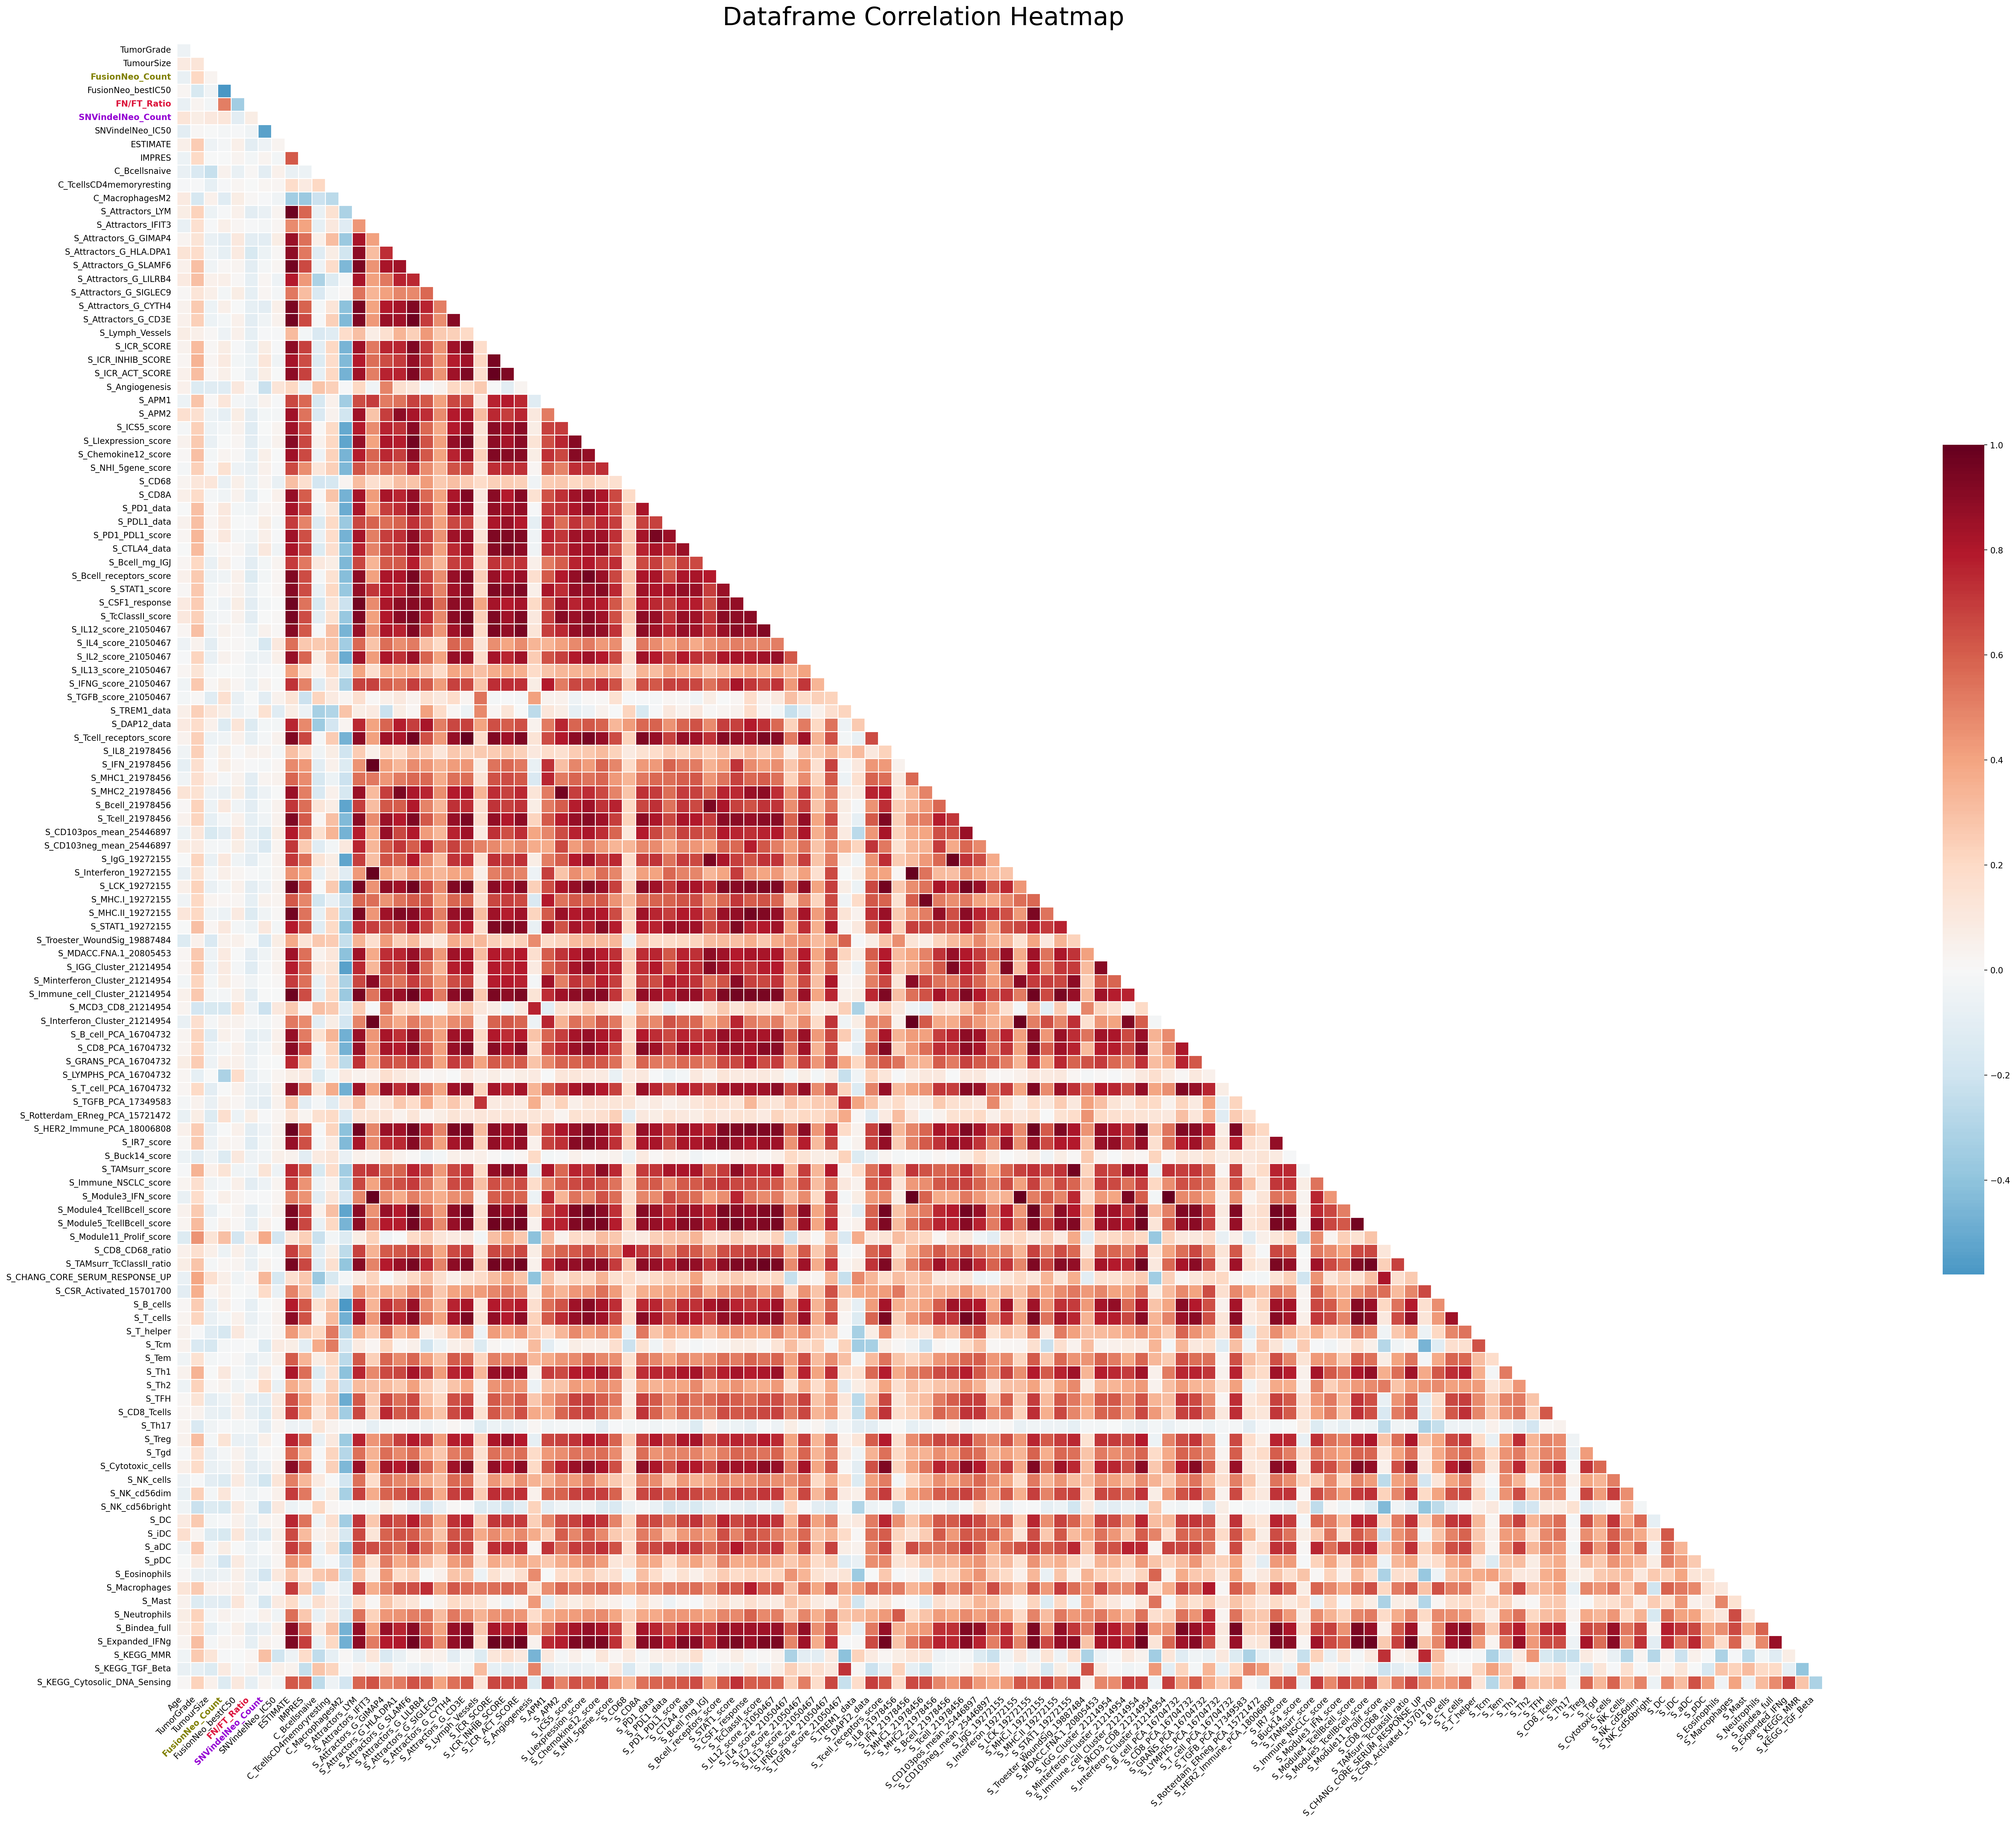

In [100]:
# replot heatmap on transformed data
corr_df = df_dcat.corr(method='spearman')
corr_df = corr_df.round(2)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(46, 36))

# Create the correlation matrix and represent it as a heatmap.
hm = sns.heatmap(corr_df, annot = False, cmap = 'RdBu_r', square = True, linewidths=0.5, center=0, mask=mask, cbar_kws={"shrink": .5})

# Get current labels
ylabels = hm.get_yticklabels()
xlabels = hm.get_xticklabels()

# Hide the first y-axis label and the last x-axis label
ylabels[0].set_visible(False)
xlabels[-1].set_visible(False)

# Rotate and align the tick labels
plt.setp(xlabels, rotation=45, ha='right')

# Define columns to highlight and their colors
highlight_cols = {
    "FN/FT_Ratio": "crimson",
    "FusionNeo_Count": "olive",
    "SNVindelNeo_Count": "darkviolet"
}

# Change color of specific x-axis and y-axis labels
for label in xlabels:
    if label.get_text() in highlight_cols:
        label.set_color(highlight_cols[label.get_text()])
        label.set_fontweight('bold')

for label in ylabels:
    if label.get_text() in highlight_cols:
        label.set_color(highlight_cols[label.get_text()])
        label.set_fontweight('bold')

# Removes all ticks
hm.tick_params(left=False, bottom=False)

hm.set_title('Dataframe Correlation Heatmap', fontsize=30, x=0.45)

plt.show()

Now, draw the same on the subset Y labels grouped as `activator_T`.

In [97]:
# get the list from the dict
activator_t = imscore_series_dict['activator_T']
suppressor_t = imscore_series_dict['suppressor_T']
best_prog = imscore_series_dict['HR<1_best_10_prog']
worst_prog = imscore_series_dict['HR>1_worst_10_prog']

# combine these with the X feature set (unique only using set())
merged_cols = X_features_nocat + activator_t + suppressor_t + best_prog + worst_prog
merged_cols = list(set(merged_cols))
print(f"Total number of elements in merged_cols (unsorted): {len(merged_cols)}")

# there are repeated immune scores (at least in between two groups, can be more than two groups) so get a list of them first
from itertools import combinations
# list of all the sets
all_sets = [set(activator_t), set(suppressor_t), set(best_prog), set(worst_prog)]

# Get all possible combinations of 2 sets
set_combo = combinations(all_sets, 2)

# Find the union of all set combinations
union_of_combo = list(set.union(*[set.intersection(c1, c2) for c1, c2 in set_combo]))

print(f"Elements that overlap between at least two sets: {union_of_combo}")

# rearrange the list element order based on another list
merged_cols = [x for x in X_features_nocat] + union_of_combo + [x for x in activator_t if x not in union_of_combo] + [x for x in suppressor_t if x not in union_of_combo] + [x for x in best_prog if x not in union_of_combo] + [x for x in worst_prog if x not in union_of_combo]

print(f"Total number of elements in merged_cols (sorted by original X feature order and groups): {len(merged_cols)}")


Total number of elements in merged_cols (unsorted): 53
Elements that overlap between at least two sets: ['S_T_helper', 'S_TGFB_score_21050467', 'S_TFH', 'S_TGFB_PCA_17349583']
Total number of elements in merged_cols (sorted by original X feature order and groups): 53


In [99]:
# now subset the dcat data
df_dcat_ss = df_dcat[merged_cols]
df_dcat_ss.head()

,Age,TumorGrade,TumourSize,FusionNeo_Count,FusionNeo_bestIC50,FN/FT_Ratio,SNVindelNeo_Count,SNVindelNeo_IC50,S_T_helper,S_TGFB_score_21050467,S_TFH,S_TGFB_PCA_17349583,S_T_cells,S_Tcell_receptors_score,S_Tcell_21978456,S_CD8_Tcells,S_CD8A,S_Th17,S_Tcm,S_Tem,S_Th1,S_Cytotoxic_cells,C_TcellsCD4memoryresting,S_T_cell_PCA_16704732,S_Attractors_G_CD3E,S_Tgd,S_CD8_PCA_16704732,S_Module4_TcellBcell_score,S_Module5_TcellBcell_score,S_CD8_CD68_ratio,S_ICR_SCORE,S_ICR_ACT_SCORE,S_GRANS_PCA_16704732,S_Treg,S_CTLA4_data,S_PD1_data,S_PDL1_data,S_PD1_PDL1_score,S_IL4_score_21050467,S_IL13_score_21050467,S_TcClassII_score,S_KEGG_TGF_Beta,S_ICR_INHIB_SCORE,S_Buck14_score,S_Bcell_receptors_score,S_CD103pos_mean_25446897,S_Attractors_G_SLAMF6,S_ICS5_score,S_Lymph_Vessels,S_Rotterdam_ERneg_PCA_15721472,S_IFNG_score_21050467,S_Module11_Prolif_score,S_TREM1_data
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SD0012,50,2,2.3,20,5.79,0.476190,357,1.7,0.4132,0.4403,0.3112,0.4648,0.2395,0.2526,0.2516,0.3645,0.2942,0.2810,0.3633,0.3210,0.2599,0.2188,0.117468,0.3451,0.2765,0.1945,0.2215,0.2546,0.2730,0.2268,0.2463,0.2495,0.3614,0.2348,0.2061,0.1536,0.2530,0.2042,0.3797,0.3197,0.3435,0.3537,0.2341,0.2094,0.2764,0.2262,0.2749,0.2130,0.3203,0.2937,0.4008,0.3697,0.2907
SD0014,58,2,2.5,10,5.28,0.588235,85,4.1,0.4092,0.4496,0.3229,0.4580,0.2909,0.3290,0.3007,0.3713,0.3644,0.2645,0.3404,0.3530,0.2808,0.2985,0.207531,0.3555,0.3525,0.1977,0.2761,0.3111,0.3159,0.2395,0.3051,0.3143,0.3637,0.3182,0.2513,0.2726,0.2377,0.2553,0.4051,0.3308,0.3868,0.3470,0.2701,0.2157,0.3079,0.2859,0.3343,0.3002,0.3452,0.3266,0.4120,0.3126,0.2012
SD0015,46,2,1.8,4,11.48,0.250000,150,2.4,0.4159,0.4391,0.3225,0.4442,0.2873,0.2886,0.2830,0.3762,0.3122,0.2370,0.3520,0.3560,0.2600,0.2720,0.235337,0.3489,0.3025,0.2021,0.2671,0.2851,0.2897,0.0936,0.2622,0.2706,0.3591,0.2251,0.2004,0.1932,0.2485,0.2211,0.4038,0.3158,0.3483,0.3522,0.2304,0.2609,0.3040,0.2712,0.3015,0.3055,0.3124,0.2985,0.3986,0.2984,0.1509
SD0017,54,2,2.5,19,15.11,0.404255,1369,1.7,0.4170,0.4248,0.3525,0.4439,0.3460,0.3797,0.3693,0.3879,0.4006,0.2212,0.3275,0.3432,0.2914,0.3151,0.148387,0.3648,0.3957,0.2251,0.3174,0.3576,0.3706,0.2758,0.3589,0.3654,0.3679,0.3330,0.2922,0.3023,0.3429,0.3228,0.4092,0.3338,0.4082,0.3468,0.3341,0.2489,0.3671,0.3003,0.3912,0.3533,0.3131,0.2886,0.4190,0.3377,0.1319
SD0018,58,3,3.0,39,3.00,0.309524,382,1.6,0.3955,0.4343,0.3041,0.4654,0.2530,0.2799,0.2670,0.3523,0.2786,0.2401,0.3185,0.3066,0.2713,0.2636,0.133531,0.3393,0.3017,0.1413,0.2308,0.2758,0.3050,0.2009,0.2870,0.2955,0.3603,0.2709,0.2310,0.2363,0.2357,0.2360,0.3689,0.3172,0.3709,0.3444,0.2544,0.2237,0.3054,0.2429,0.3141,0.2892,0.3358,0.2920,0.4095,0.3770,0.2824


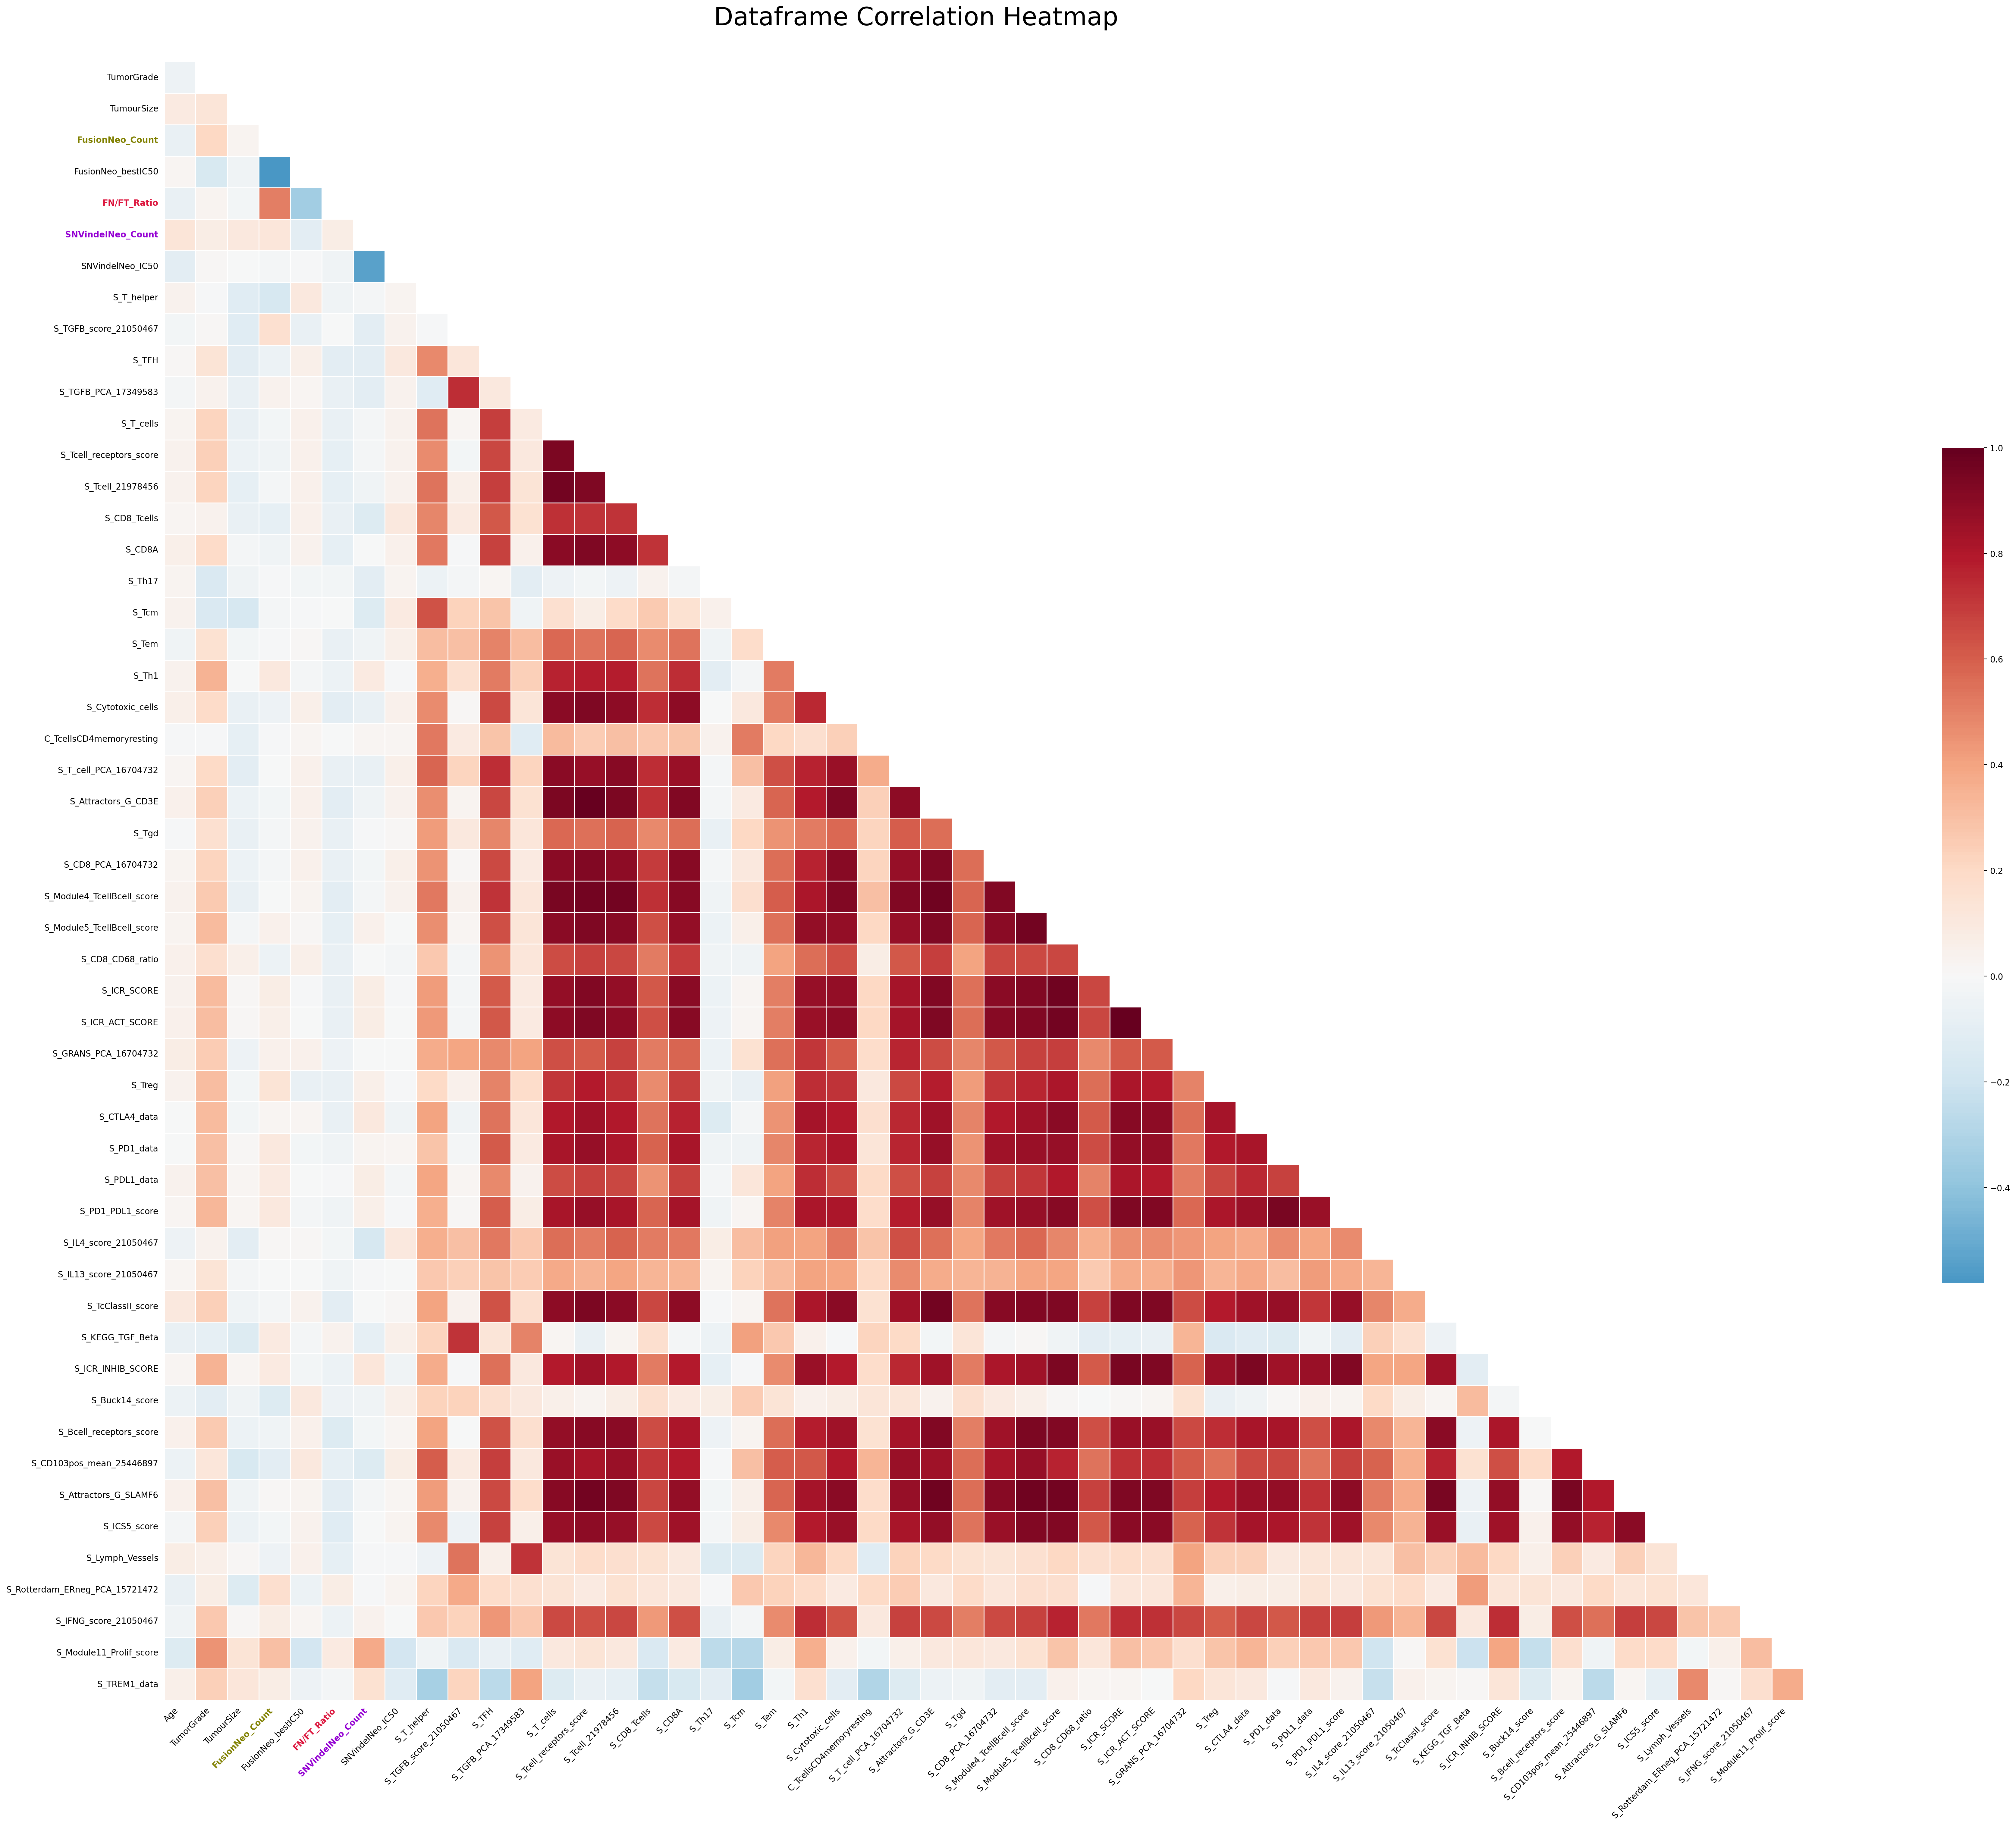

In [101]:
# replot heatmap on transformed data
corr_df = df_dcat_ss.corr(method='spearman')
corr_df = corr_df.round(2)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(46, 36))

# Create the correlation matrix and represent it as a heatmap.
hm = sns.heatmap(corr_df, annot = False, cmap = 'RdBu_r', square = True, linewidths=0.5, center=0, mask=mask, cbar_kws={"shrink": .5})

# Get current labels
ylabels = hm.get_yticklabels()
xlabels = hm.get_xticklabels()

# Hide the first y-axis label and the last x-axis label
ylabels[0].set_visible(False)
xlabels[-1].set_visible(False)

# Rotate and align the tick labels
plt.setp(xlabels, rotation=45, ha='right')

# Define columns to highlight and their colors
highlight_cols = {
    "FN/FT_Ratio": "crimson",
    "FusionNeo_Count": "olive",
    "SNVindelNeo_Count": "darkviolet"
}

# Change color of specific x-axis and y-axis labels
for label in xlabels:
    if label.get_text() in highlight_cols:
        label.set_color(highlight_cols[label.get_text()])
        label.set_fontweight('bold')

for label in ylabels:
    if label.get_text() in highlight_cols:
        label.set_color(highlight_cols[label.get_text()])
        label.set_fontweight('bold')

# Removes all ticks
hm.tick_params(left=False, bottom=False)

hm.set_title('Dataframe Correlation Heatmap', fontsize=30, x=0.45)

plt.show()

#### **Split Dataset with `train_test_split`**

Split the dataset before modeling to avoid information leakage, then preprocess the data through the set up Pipeline before XGBoost.

In [ ]:
# subset X features; use the list generated before
X = dfx2_[X_features]
X

Now grab the Y targets (do this as a whole, but we will train on each column individually later).

In [ ]:
# Now get the Y variable set
cols_y = [col for col in dfx2_.drop(columns=['Batch', 'Stage', 'FusionTransscript_Count']).columns if col not in X.columns]
Y = dfx2_[list(cols_y)]
Y

Now we perform train test split on the X and Y variables.

In [40]:
# Perform train-test split
X_train, X_test, Y_train, Y_test = skl.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
X_train.info()

In [ ]:
X_test.info()

As we don't want to transform all the X columns (because some of them are discrete numerical data and some of them are one-hot encoded categorical variables), we need to specify the columns to transform.

In [45]:
X_vars_to_transform = ['TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

First, apply the Yeo-Johnson transformation on the split datasets.

In [46]:
from feature_engine.transformation import YeoJohnsonTransformer

# Initialize Yeo-Johnson transformer for features to transform
yj_transformer_X = YeoJohnsonTransformer(variables=X_vars_to_transform)

# Initialize Yeo-Johnson transformer for target
yj_transformer_Y = YeoJohnsonTransformer()

# Fit and transform the training data (features)
X_train_yj = yj_transformer_X.fit_transform(X_train)

# Transform the test data using the fitted transformer (features)
X_test_yj = yj_transformer_X.transform(X_test)

# Fit and transform the training data (targets)
Y_train_yj = yj_transformer_Y.fit_transform(Y_train)

# Transform the test data using the fitted transformer (targets)
Y_test_yj = yj_transformer_Y.transform(Y_test)


In [ ]:
X_train_yj.head()

In [ ]:
Y_test.head()

In [49]:
Y_test_inversed = yj_transformer_Y.inverse_transform(Y_test_yj)

In [ ]:
Y_test_inversed.head()

**DEPRECATED** ~~Then, apply z-score standardization.~~

In [51]:
# from scipy.stats import zscore
# # Apply Z-score normalization to Yeo-Johnson transformed columns
# for col in X_vars_to_transform:
#     X_train_tf[col] = zscore(X_train_tf[col])
#     X_test_tf[col] = zscore(X_test_tf[col])

# X_train_tfz = X_train_tf.copy()
# X_test_tfz = X_test_tf.copy()

# # using lambda function to apply z-score to each column
# zs = lambda x : zscore(x)
# Y_train_tfz = Y_train_tf.apply(zs)
# Y_test_tfz = Y_test_tf.apply(zs)

Let's use Standard Scaler instead (but wrap with with `feature_engine`'s wrapper).

In [52]:
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

# select variables to transform
cols_X = X_train_yj.columns.tolist()
cols_X = [col for col in cols_X if col not in ['Age', 'TumorGrade', 'Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']]

# set up the wrapper with the StandardScaler
scaler_X = SklearnTransformerWrapper(transformer = StandardScaler(),
                                    variables = cols_X)

# fit the wrapper + StandardScaler
scaler_X.fit(X_train_yj)

# transform the data
X_train_yjz = scaler_X.transform(X_train_yj)
X_test_yjz = scaler_X.transform(X_test_yj)


In [ ]:
X_train_yj

In [ ]:
X_train_yjz

Now test if we can inverse-transform the Scaler step.

In [ ]:
X_train_yj_inversed = scaler_X.inverse_transform(X_train_yjz)
X_train_yj_inversed

In [ ]:
Y_train_yj

In [ ]:
# select variables to transform for Y
cols_Y = Y_train_yj.columns.tolist()

# set up the wrapper with the StandardScaler
scaler_Y = SklearnTransformerWrapper(transformer = StandardScaler(),
                                    variables = cols_Y)

# fit the wrapper + StandardScaler
scaler_Y.fit(Y_train_yj)

# transform the data
Y_train_yjz = scaler_Y.transform(Y_train_yj)
Y_test_yjz = scaler_Y.transform(Y_test_yj)
Y_train_yjz

#### **Create a Pipeline from `feature_engine` Package**
This would enable easy inverse transform steps for both X and Y.

In [58]:
from feature_engine.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

X_vars_to_transform = ['TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

# select variables to scale
scale_cols_X = X_train.columns.tolist()
scale_cols_X = [col for col in scale_cols_X if col not in ['Age', 'TumorGrade', 'Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']]

# Create the pipeline
preprocess_pipeline_X = Pipeline([
    ('yeo_johnson', YeoJohnsonTransformer(variables=X_vars_to_transform)),
    ('scaler', SklearnTransformerWrapper(transformer = StandardScaler(), variables = scale_cols_X))
])

# Fit the pipeline to the training data
preprocess_pipeline_X.fit(X_train)

# Transform the training data
X_train_yjsc = preprocess_pipeline_X.transform(X_train)
# Transform the test data
X_test_yjsc = preprocess_pipeline_X.transform(X_test)


In [ ]:
X_train

In [ ]:
X_train_yjz

In [ ]:
X_train_yjsc

In [ ]:
## Try inverse transform on the pipeline
X_train_inv = preprocess_pipeline_X.inverse_transform(X_train_yjsc)
X_train_inv

The Pipeline worked! Now we can do the same with Y.

In [63]:
from feature_engine.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

# select variables to scale
scale_cols_Y = Y_train.columns.tolist()

# Create the pipeline
preprocess_pipeline_Y = Pipeline([
    ('yeo_johnson', YeoJohnsonTransformer()),
    ('scaler', SklearnTransformerWrapper(transformer = StandardScaler(), variables = scale_cols_Y))
])

# Fit the pipeline to the training data
preprocess_pipeline_Y.fit(Y_train)

# Transform the training data
Y_train_yjsc = preprocess_pipeline_Y.transform(Y_train)
# Transform the test data
Y_test_yjsc = preprocess_pipeline_Y.transform(Y_test)

In [ ]:
Y_test

In [ ]:
Y_test_yjz

In [ ]:
Y_test_yjsc

In [ ]:
## try inverse transform
Y_test_inv = preprocess_pipeline_Y.inverse_transform(Y_test_yjsc)
Y_test_inv

#### **XGBoost Learning**

Time to test XGBoost. Select `ESTIMATE` column as the first target/label (`y`) variable first.

In [ ]:
# Extract ESTIMATE column as y label
y_target = 'ESTIMATE'
Y_train_targ = Y_train_yjsc[y_target]
Y_test_targ = Y_test_yjsc[y_target]

print(Y_train_targ.shape)
print(Y_test_targ.shape)

With `y` label selected, create DMatrix objects for XGBoost corresponding to the `X_train_yjsc` and `X_test_yjsc` sets.

In [69]:
# Create DMatrix for XGBoost; enable_categorical=True if there are categorical encoded columns
dtrain = xgb.DMatrix(X_train_yjsc, label=Y_train_targ, enable_categorical=True)
dtest = xgb.DMatrix(X_test_yjsc, label=Y_test_targ, enable_categorical=True)

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Train the model
num_rounds = 150
model = xgb.train(params, dtrain, num_rounds)

# Make predictions
y_transformed_preds = model.predict(dtest)

In [ ]:
len(y_transformed_preds)

~~Now that XGBoost training and modeling have been completed, we can reverse the Z-score scaling and YJ transformation in the order they were applied. Make sure to use the pre-scaled mean and standard deviation for the z-score reversal.~~

Use the Pipeline object to inverse transform. Make sure to make a dummy dataFrame for the predicted Y array first because the Pipeline object were created based off a dataFrame.

In [71]:
# mean_y = Y_train_tf[y_index].mean()
# print(mean_y)
# std_y = Y_train_tf[y_index].std()
# print(std_y)
# # Step 1: Reverse Z-score normalization
# preds_rev_z = (preds_tf * std_y) + mean_y
# preds_rev_z

In [ ]:
# Create a DataFrame with the same columns as the original y used in fit
dummy_y = pd.DataFrame(0, index=X_test_yjsc.index, columns=Y_test_yjsc.columns)
dummy_y[y_target] = y_transformed_preds
dummy_y

In [ ]:
# apply inverse transform
dummy_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_y)
dummy_y_inv

In [ ]:
# Extract the relevant target column
y_preds = dummy_y_inv[y_target].to_numpy()
y_preds

#### **Model Evaluation**

Import Scikit-Learn's `metrics` tools to evaluate the machine learning outputs. 

In [ ]:
# Evaluate
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(Y_test[y_target], y_preds))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(Y_test[y_target], y_preds)
r2 = r2_score(Y_test[y_target], y_preds)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

It is worth keeping in mind that these metrics are based on one split of the full dataset (seed of 42) during the `train_test_split`, and using default hyperparameters. 

Regardless, let's look at the built-in feature importance plots as well as SHAP-analyzed feature importance plots.

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(model, ax=ax)
plt.show()

In [ ]:
import shap
# Create the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_yjsc)

# Summary plot
shap.summary_plot(shap_values, X_train_yjsc)

In [ ]:
import shap

# Create the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values on the test set
shap_values_test = explainer.shap_values(X_test_yjsc)

# Summary plot for test set
shap.summary_plot(shap_values_test, X_test_yjsc)

# Optionally, you can still calculate and compare with training set
shap_values_train = explainer.shap_values(X_train_yjsc)

# Compare summary plots
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(121)
shap.summary_plot(shap_values_test, X_test_yjsc, plot_type="bar", show=False)
plt.title("Test Set SHAP Values")
plt.subplot(122)
shap.summary_plot(shap_values_train, X_train_yjsc, plot_type="bar", show=False)
plt.title("Train Set SHAP Values")
plt.tight_layout()
plt.show()

In [ ]:
# Feature importance based on mean absolute SHAP values
feature_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame(list(zip(X_test_yjsc.columns, feature_importance)),
                                     columns=['feature', 'importance'])
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("Top 10 features by SHAP importance based on the test set:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_df.plot(x='feature', y='importance', kind='bar')
plt.title('Feature Importance (Mean Absolute SHAP Values)')
plt.xlabel('Features')
plt.ylabel('Mean |SHAP Value|')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# SHAP dependence plot for the most important feature
# most_important_feature = feature_importance_df.iloc[0]['feature']
# shap.dependence_plot(most_important_feature, shap_values, X_train_tfz)

In [ ]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer(X_train_yjsc)

# Perform clustering
clust = shap.utils.hclust(X_train_yjsc, Y_train_targ)

# Create the bar plot with clustering
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [ ]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer(X_test_yjsc)

# Perform clustering
clust = shap.utils.hclust(X_test_yjsc, Y_test_targ)

# Create the bar plot with clustering
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [ ]:
# Create SHAP explainers
explainer_original = shap.TreeExplainer(model)
explainer_transformed = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values_original = explainer_original(X_test)
shap_values_transformed = explainer_transformed(X_test_yjsc)

# Function to plot and compare SHAP summary plots
def compare_shap_plots(shap_values_orig, shap_values_trans, X_orig, X_trans):
    plt.figure(figsize=(60, 30))
    plt.subplot(121)
    shap.summary_plot(shap_values_orig, X_orig, plot_type="bar", show=False)
    plt.title("SHAP Values - Original Features")

    plt.subplot(122)
    shap.summary_plot(shap_values_trans, X_trans, plot_type="bar", show=False)
    plt.title("SHAP Values - Transformed Features")

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    plt.show()

# Compare SHAP plots
compare_shap_plots(shap_values_original, shap_values_transformed, X_test, X_test_yjsc)

# Function to get feature importance from SHAP values
def get_feature_importance(shap_values, feature_names):
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_importance_df = pd.DataFrame(list(zip(feature_names, feature_importance)),
                                         columns=['feature', 'importance'])
    return feature_importance_df.sort_values('importance', ascending=False)

# Get and compare feature importances
importance_original = get_feature_importance(shap_values_original, X_test.columns)
importance_transformed = get_feature_importance(shap_values_transformed, X_test.columns)

# print("Top 10 features (Original):")
# print(importance_original.head(10))
# print("\nTop 10 features (Transformed):")
# print(importance_transformed.head(10))

# For specific feature analysis, use dependence plots
# shap.dependence_plot(importance_original.iloc[2]['feature'], shap_values_original.values, X_train)
# shap.dependence_plot(importance_transformed.iloc[2]['feature'], shap_values_transformed.values, X_train_tfz)

#### **Packaging the ML Workflow for Iterative Analyses**

The code above is running XGBoost using its native API. Let's rerun XGBoost using `scikit-learn` API. Expect similar output because different interfaces are cosmetic and should not affect underlying computation. Many of the steps will be packaged into functions as well to allow iterative analyses on different Y target columns.

In [83]:
### DEPRECATED ###
# dfc_updated = dfc.drop(columns=['Stage', 'FusionTransscript_Count', 'Age'])
# clin_features = ['TumorGrade', 'TumourSize', 'FusionNeo_bestIC50', 'FusionNeo_Count', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']
# # define X features; use the clin_features list generated before
# X = dfc_updated[clin_features]

# # Now get the Y variable set
# cols_y = [col for col in dfc_updated.columns if col not in X.columns]
# Y = dfc_updated[list(cols_y)]

Remove `Stage` and `FusionTransscript_Count` features as they are deemed less important in the SHAP analysis above.

In [ ]:
dfc = dfx2_.drop(columns=['Batch', 'Stage', 'FusionTransscript_Count'])

clin_features = ['Age', 'TumorGrade', 'TumourSize', 'Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

X = dfc[clin_features]
X

In [ ]:
# get the Y set
cols_y = [col for col in dfc.columns if col not in X.columns]
Y = dfc[list(cols_y)]
Y

In [86]:
# Perform train-test split
X_train, X_test, Y_train, Y_test = skl.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# load modules for transformation
from feature_engine.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

# select X features to transform
X_vars_to_transform = ['TumourSize', 'FusionNeo_Count', 'FusionNeo_bestIC50', 'FN/FT_Ratio', 'SNVindelNeo_Count', 'SNVindelNeo_IC50']

# select variables to scale
scale_cols_X = X_train.columns.tolist()
scale_cols_X = [col for col in scale_cols_X if col not in ['Age', 'TumorGrade', 'Subtype_HR+/HER2-', 'Subtype_HR+/HER2+', 'Subtype_TNBC', 'Subtype_HR-/HER2+']]

# Create the pipeline
preprocess_pipeline_X = Pipeline([
    ('yeo_johnson', YeoJohnsonTransformer(variables=X_vars_to_transform)),
    ('scaler', SklearnTransformerWrapper(transformer = StandardScaler(), variables = scale_cols_X))
])

# Fit the pipeline to the training data
preprocess_pipeline_X.fit(X_train)

# Transform the training data
X_train_yjsc = preprocess_pipeline_X.transform(X_train)
# Transform the test data
X_test_yjsc = preprocess_pipeline_X.transform(X_test)

#### Y Labels ####
# select variables to scale
scale_cols_Y = Y_train.columns.tolist()

# Create the pipeline
preprocess_pipeline_Y = Pipeline([
    ('yeo_johnson', YeoJohnsonTransformer()),
    ('scaler', SklearnTransformerWrapper(transformer = StandardScaler(), variables = scale_cols_Y))
])

# Fit the pipeline to the training data
preprocess_pipeline_Y.fit(Y_train)

# Transform the training data
Y_train_yjsc = preprocess_pipeline_Y.transform(Y_train)
# Transform the test data
Y_test_yjsc = preprocess_pipeline_Y.transform(Y_test)

print("Shapes after transformations:")
print("Transformed X_train:", X_train_yjsc.shape)
print("Transformed X_test:", X_test_yjsc.shape)
print("Transformed Y_train:", Y_train_yjsc.shape)
print("Transformed Y_test:", Y_test_yjsc.shape)

# Extract ESTIMATE column as y label
y_target = 'ESTIMATE'
y_train_targ = Y_train_yjsc[y_target]
y_test_targ = Y_test_yjsc[y_target]
print(y_train_targ)
print(y_test_targ)

In [ ]:
from xgboost import XGBRegressor

model_xgbreg = XGBRegressor(n_estimators=150, random_state=42)

# fit
model_xgbreg.fit(X_train_yjsc, y_train_targ)

# predict
y_transformed_train_pred = model_xgbreg.predict(X_train_yjsc)
y_transformed_test_pred = model_xgbreg.predict(X_test_yjsc)

# Create a DataFrame with the same columns as the original y used in fit
dummy_train_y = pd.DataFrame(0, index=X_train_yjsc.index, columns=Y_train_yjsc.columns)
dummy_train_y[y_target] = y_transformed_train_pred

dummy_test_y = pd.DataFrame(0, index=X_test_yjsc.index, columns=Y_test_yjsc.columns)
dummy_test_y[y_target] = y_transformed_test_pred

# apply inverse transform
dummy_train_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_train_y)
dummy_test_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_test_y)

# Extract the relevant target column
y_train_pred = dummy_train_y_inv[y_target].to_numpy()
y_test_pred = dummy_test_y_inv[y_target].to_numpy()

# Evaluate
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
train_r2 = r2_score(Y_train[y_target], y_train_pred)
test_r2 = r2_score(Y_test[y_target], y_test_pred)

train_rmse = np.sqrt(mean_squared_error(Y_train[y_target], y_train_pred))
test_rmse = np.sqrt(mean_squared_error(Y_test[y_target], y_test_pred))

train_mae = mean_absolute_error(Y_train[y_target], y_train_pred)
test_mae = mean_absolute_error(Y_test[y_target], y_test_pred)

# Print results
print("Model Performance:")
print(f"{'Metric':<10} {'Train':<10} {'Test':<10}")
print("-" * 30)
print(f"{'R2':<10} {train_r2:<10.4f} {test_r2:<10.4f}")
print(f"{'RMSE':<10} {train_rmse:<10.4f} {test_rmse:<10.4f}")
print(f"{'MAE':<10} {train_mae:<10.4f} {test_mae:<10.4f}")

# Plot actual vs predicted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(Y_train[y_target], y_train_pred, alpha=0.5)
ax1.plot([Y_train[y_target].min(), Y_train[y_target].max()], [Y_train[y_target].min(), Y_train[y_target].max()], 'r--', lw=2)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Train Set')

ax2.scatter(Y_test[y_target], y_test_pred, alpha=0.5)
ax2.plot([Y_test[y_target].min(), Y_test[y_target].max()], [Y_test[y_target].min(), Y_test[y_target].max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title('Test Set')

plt.tight_layout()
plt.close()

##### OBSOLETE
# rmse = np.sqrt(mean_squared_error(Y_test[y_target], y_test_pred))
# print(f"RMSE: {rmse}")
# mae = mean_absolute_error(Y_test[y_target], y_test_pred)
# r2 = r2_score(Y_test[y_target], y_test_pred)
# print(f"Mean Absolute Error: {mae}")
# print(f"R-squared Score: {r2}")

# Feature importance
fig, ax = plt.subplots(figsize=(18, 16), dpi=300)
plot_importance(model_xgbreg, ax=ax)
plt.show()

import shap
# Create the SHAP explainer
explainer = shap.TreeExplainer(model_xgbreg)

# run explanation object on X_test dataset because we don't want to learn what the model learned from the X_train data, but to see features that would influence predictions on new data
shap_values = explainer(X_test_yjsc)

plt.figure(figsize=(18, 16)) 
# Summary plot
shap.summary_plot(shap_values, show=False)
plt.tight_layout()
plt.show()

# Perform clustering
clust = shap.utils.hclust(X_test_yjsc, y_test_targ)
# Create the bar plot with clustering
plt.figure(figsize=(18, 16)) 
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1, show=False)
plt.tight_layout()
plt.show()


#### **Iterative Learning over all Y labels**

The learning using XGBoost above was done on just one Y label, which is the `ESTIMATE` column. Let's put these into a set of functions so we can run this process iteratively on all Y columns we have set up.

In [89]:
# copy the steps above as a function
import os 
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class YTargetMetrics:
    def __init__(self, target_name, train_r2, test_r2, train_rmse, test_rmse, train_mae, test_mae):
        self.target_name = target_name
        self.train_r2 = train_r2
        self.test_r2 = test_r2
        self.train_rmse = train_rmse
        self.test_rmse = test_rmse
        self.train_mae = train_mae
        self.test_mae = test_mae

    def __str__(self):
        return f"""Model Performance for {self.target_name}:
{'Metric':<10} {'Train':<10} {'Test':<10}
{'-' * 30}
{'R2':<10} {self.train_r2:<10.4f} {self.test_r2:<10.4f}
{'RMSE':<10} {self.train_rmse:<10.4f} {self.test_rmse:<10.4f}
{'MAE':<10} {self.train_mae:<10.4f} {self.test_mae:<10.4f}"""

    def to_dict(self):
        return {
            'target_name': self.target_name,
            'train_r2': self.train_r2,
            'test_r2': self.test_r2,
            'train_rmse': self.train_rmse,
            'test_rmse': self.test_rmse,
            'train_mae': self.train_mae,
            'test_mae': self.test_mae
        }

def plot_learning_curves(estimator, X, y, target, cv=5, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes,
        scoring='neg_mean_squared_error')
    
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

    # Create 'plots' directory if it doesn't exist
    os.makedirs(f'plots/{target}', exist_ok=True)

    # Save the plot
    plt.savefig(f'plots/{target}/{target}-xgb-def-model-learning-curve.png')
    plt.close()

def run_xgboost_model(model_instance, y_target, Y_train, Y_test, X_train_transformed, X_test_transformed, Y_train_transformed, Y_test_transformed, preprocess_pipeline_Y):
    # assign untransformed, raw target data
    raw_y_train = Y_train[y_target]
    raw_y_test = Y_test[y_target]

    # fit
    model_instance.fit(X_train_transformed, Y_train_transformed[y_target])
    
    # predict
    y_train_pred_transformed = model_instance.predict(X_train_transformed)
    y_test_pred_transformed = model_instance.predict(X_test_transformed)

    # Create a DataFrame with the same columns as the original y used in fit
    dummy_train_y = pd.DataFrame(0, index=X_train_transformed.index, columns=Y_train_transformed.columns)
    dummy_train_y[y_target] = y_train_pred_transformed

    dummy_test_y = pd.DataFrame(0, index=X_test_transformed.index, columns=Y_test_transformed.columns)
    dummy_test_y[y_target] = y_test_pred_transformed

    # apply inverse transform
    dummy_train_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_train_y)
    dummy_test_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_test_y)

    # Extract the relevant target column
    y_train_pred = dummy_train_y_inv[y_target].to_numpy()
    y_test_pred = dummy_test_y_inv[y_target].to_numpy()

    # Evaluate model
    # Calculate metrics
    train_r2 = r2_score(raw_y_train, y_train_pred)
    test_r2 = r2_score(raw_y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(raw_y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(raw_y_test, y_test_pred))

    train_mae = mean_absolute_error(raw_y_train, y_train_pred)
    test_mae = mean_absolute_error(raw_y_test, y_test_pred)

    # Plot learning curves
    plot_learning_curves(model_instance, X_train_transformed, Y_train_transformed[y_target], y_target)

    # Print results
    # print("Model Performance:")
    # print(f"{'Metric':<10} {'Train':<10} {'Test':<10}")
    # print("-" * 30)
    # print(f"{'R2':<10} {train_r2:<10.4f} {test_r2:<10.4f}")
    # print(f"{'RMSE':<10} {train_rmse:<10.4f} {test_rmse:<10.4f}")
    # print(f"{'MAE':<10} {train_mae:<10.4f} {test_mae:<10.4f}")

    # Plot actual vs predicted
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    ax1.scatter(raw_y_train, y_train_pred, alpha=0.5)
    ax1.plot([raw_y_train.min(), raw_y_train.max()], [raw_y_train.min(), raw_y_train.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.set_title('Training Set')

    ax2.scatter(raw_y_test, y_test_pred, alpha=0.5)
    ax2.plot([raw_y_test.min(), raw_y_test.max()], [raw_y_test.min(), raw_y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_title('Testing Set')

    plt.tight_layout()

    # Create 'plots' directory if it doesn't exist
    os.makedirs(f'plots/{y_target}', exist_ok=True)

    plt.savefig(f'plots/{y_target}/{y_target}-xgb-def-model-performance-comparison.png')
    plt.close()

    ##### OBSOLETE
    # rmse = np.sqrt(mean_squared_error(Y_test[y_target], y_test_pred))
    # print(f"RMSE: {rmse}")
    # mae = mean_absolute_error(Y_test[y_target], y_test_pred)
    # r2 = r2_score(Y_test[y_target], y_test_pred)
    # print(f"Mean Absolute Error: {mae}")
    # print(f"R-squared Score: {r2}")

    # Feature importance
    _, ax = plt.subplots(figsize=(18, 16), dpi=300)
    plot_importance(model_instance, ax=ax)

    plt.savefig(f"plots/{y_target}/{y_target}-xgb-def-model-test-set-feature-importance.png")
    plt.close()

    # Create the SHAP explainer
    explainer = shap.TreeExplainer(model_instance)

    # run explanation object on X_test dataset because we don't want to learn what the model learned from the X_train data, but to see features that would influence predictions on new data
    shap_values = explainer(X_test_transformed)

    plt.figure(figsize=(18, 16), dpi=300) 
    # Summary plot
    shap.summary_plot(shap_values, show=False)
    plt.tight_layout()
    plt.savefig(f"plots/{y_target}/{y_target}-xgb-def-model-test-set-SHAP-beeswarm.png", bbox_inches='tight')
    plt.close()

    # Perform clustering
    clust = shap.utils.hclust(X_test_transformed, Y_test_transformed[y_target])
    # Create the bar plot with clustering
    plt.figure(figsize=(18, 16)) 
    shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1, show=False)
    plt.tight_layout()
    plt.savefig(f"plots/{y_target}/{y_target}-xgb-def-model-test-set-SHAP-summary.png", dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Model training and evaluation for {y_target} completed.")

    # Instead of returning a tuple, return a YTargetMetrics object
    return YTargetMetrics(y_target, train_r2, test_r2, train_rmse, test_rmse, train_mae, test_mae)


Now test the functions.

In [ ]:
# initialize an empty dictionary to store the results
results = {}

# instantiate model
model_xgbreg = XGBRegressor(n_estimators=150, random_state=42)

for target in cols_y:
    metrics = run_xgboost_model(model_xgbreg, target, Y_train, Y_test, X_train_yjsc, X_test_yjsc, Y_train_yjsc, Y_test_yjsc, preprocess_pipeline_Y)
    # Store the metric result in the dictionary
    results[target] = metrics

In [ ]:
import json

# Now you can easily access and print metrics
for target, metrics in results.items():
    print(metrics)  # This will use the __str__ method of YTargetMetrics

# If you need to convert back to a dictionary (e.g., for saving to JSON)
results_dict = {target: metrics.to_dict() for target, metrics in results.items()}

# Save to a JSON file
with open('out_files/xgboost_default_model_evaluation_metrics.json', 'w') as f:
    json.dump(results_dict, f, indent=4)

It appears that the testing R2 are poor. This means that there is an issue of overfitting. 

#### **Grid Search: Using `GridSearchCV` for Hyperparameter Tuning**

In [92]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# def run_grid_search_cv(model_instance, target, param_grid, X_train_transformed, Y_train_transformed):
#     print(target)

#     # assign y target column
#     y_train_target = Y_train_transformed[target]
    
#     # Set up grid search
#     grid_search = GridSearchCV(
#     estimator=model_instance,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,  # Use all available cores
#     verbose=1
#     )
    
#     print(f"Running grid search on {target} column...")
#     # Fit grid search
#     grid_search.fit(X_train_transformed, y_train_target)

#     # Get best parameters and model
#     best_params = grid_search.best_params_
#     best_model = grid_search.best_estimator_

#     print("Best parameters:", best_params)
#     print("Best score:", -grid_search.best_score_)

#     return best_model, best_params

# def predict_with_best_xgboost_model(best_model, target, X_test_transformed, Y_test_transformed, Y_test_raw, preprocess_pipeline_Y):
#     # Make predictions on the test set using the best model
#     y_pred_transformed = best_model.predict(X_test_transformed)

#     # Create a DataFrame with the same columns as the original y used in preprocess_pipeline to reverse transformation
#     dummy_y = pd.DataFrame(0, index=X_test_transformed.index, columns=Y_test_transformed.columns)
#     dummy_y[target] = y_pred_transformed

#     # apply inverse transform
#     dummy_y_inv = preprocess_pipeline_Y.inverse_transform(dummy_y)

#     # Extract the relevant target column
#     y_pred = dummy_y_inv[target].to_numpy()

#     # Evaluate
#     y_test_raw = Y_test_raw[target]
#     mae = mean_absolute_error(y_test_raw, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test_raw, y_pred))
#     r2 = r2_score(y_test_raw, y_pred)

#     print(f"Mean Absolute Error (MAE) [Testing]: {mae:.2f}")
#     print(f"Root Mean Squared Error (RMSE) [Testing]: {rmse:.2f}")
#     print(f"Coefficient of Determination (R2) [Testing]: {r2:.2f}")

#     return mae, rmse, r2

In [93]:
# # Instantiate base model
# model_xgb = XGBRegressor(random_state=42)

# # Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.5, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3, 0.8, 1]
# }

# # initialize an empty dict
# tuned_results = {}

# for target in cols_y[:2]:
#     best_model, best_params = run_grid_search_cv(model_xgb, target, param_grid, X_train_yjsc, Y_train_yjsc)
    
#     tuned_metrics = predict_with_best_xgboost_model(best_model, target, X_test_yjsc, Y_test_yjsc, Y_test, preprocess_pipeline_Y)

#     # Store the metric result in the dictionary
#     tuned_results[target] = tuned_metrics